In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import tree

In [2]:
%matplotlib inline

### Load boston dataset

In [3]:
boston = load_boston()

In [4]:
boston['data'][:3]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   7.18500000e+00,
          6.11000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.92830000e+02,
          4.03000000e+00]])

In [5]:
boston['target'][:3]

array([ 24. ,  21.6,  34.7])

In [6]:
X, y = boston['data'], boston['target']

In [7]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


### Train-test-split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Test sklearn.tree.DecisionTreeRegressor

In [9]:
def test(est, X_train, y_train, X_test, y_test, score_metric):
    est.fit(X_train, y_train)
    train_score = score_metric(y_train, est.predict(X_train))
    test_score  = score_metric(y_test , est.predict(X_test ))
    return train_score, test_score

In [10]:
def plot(est_class, X_train, y_train, X_test, y_test, score_metric, arg_name, arg_values, subplot_args=[], subplot_kwargs={}):
    train_scores = []
    test_scores  = []
    for value in arg_values:
        train_score, test_score = test(est_class(**{arg_name:value}), X_train, y_train, X_test, y_test, score_metric)
        train_scores.append(train_score)
        test_scores.append(test_score)
    subplot = plt.subplot(*subplot_args, **subplot_kwargs)
    subplot.plot(arg_values, train_scores, '.--')
    subplot.plot(arg_values, test_scores , 'x--')
    subplot.legend(['train_score', 'test_score'])
    return subplot

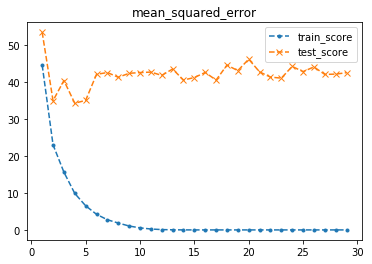

In [11]:
plot(tree.DecisionTreeRegressor, X_train, y_train, X_test, y_test, mean_squared_error, 'max_depth', range(1, 30))
plt.title('mean_squared_error')
plt.show()

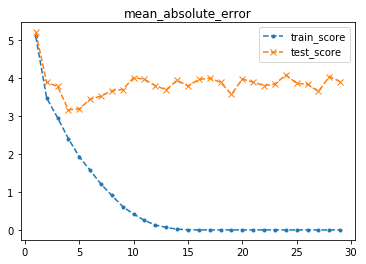

In [12]:
plot(tree.DecisionTreeRegressor, X_train, y_train, X_test, y_test, mean_absolute_error, 'max_depth', range(1, 30))
plt.title('mean_absolute_error')
plt.show()

### Implement my DecisionTree class

In [13]:
# mse split criterion
# each index can produce only 10 possible bounds => split complexity ~ (1 + log)(X.shape[0]) * X.shape[1] * 10
class DecisionTree(object):
    def __init__(self, max_depth=100):
        self.max_depth = max_depth
    
    def fit(self, X, y):
        self.root = self.Node(self, X, y)
    
    def predict(self, X):
        return np.asarray(list(self.root.predict(x) for x in X))
    
    class Node(object):
        def __init__(self, dt, X, y, depth=0):
            self.is_leaf = (depth >= dt.max_depth) or (X.shape[0] == 1)
            self.y = np.mean(y)
            if not self.is_leaf:
                self.ind = None
                self.bound = None
                self.error = None
                for ind, bounds in self.__compute_inds_and_bounds(X, y):
                    for bound in bounds:
                        cur_error = self.__error_function(X, y, ind, bound)
                        if (self.error is None) or (cur_error < self.error):
                            self.ind = ind
                            self.bound = bound
                            self.error = cur_error
                if self.error is None:
                    self.is_leaf = True
                    self.y = np.mean(y)
                else:
                    X_left, y_left, X_right, y_right = self.__split_by_ind_and_bound(X, y, self.ind, self.bound)
                    self.left  = dt.Node(dt, X_left , y_left , depth + 1)
                    self.right = dt.Node(dt, X_right, y_right, depth + 1)
                
        def predict(self, x):
            if self.is_leaf:
                return self.y
            else:
                child = self.left if x[self.ind] <= self.bound else self.right
                return child.predict(x)
        
        def __compute_inds_and_bounds(self, X, y):
            for ind in range(X.shape[1]):
                levels = np.unique(X[:, ind])
                step = max(1, levels.shape[0] // 10)
                yield ind, levels[:-1:step]
        
        def __split_by_ind_and_bound(self, X, y, ind, bound):
            left_inds = X[:, ind] <= bound
            right_inds = np.logical_not(left_inds)
            return X[left_inds], y[left_inds], X[right_inds], y[right_inds]
        
        def __error_function(self, X, y, ind, bound):
            inds = X[:, ind] <= bound
            left_y  = y[inds]
            right_y = y[np.logical_not(inds)]
            return left_y.shape[0] * np.var(left_y) + right_y.shape[0] * np.var(right_y)

### Compare my DecisionTree with sklearn.tree.DecisionTreeRegressor

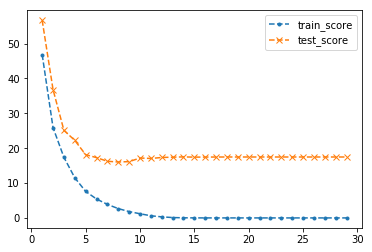

In [14]:
plot(DecisionTree, X_train, y_train, X_test, y_test, mean_squared_error, 'max_depth', range(1, 30))

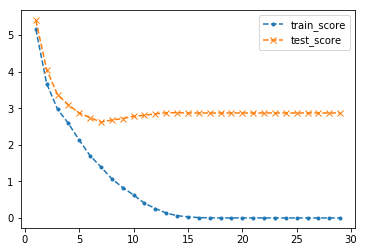

In [15]:
plot(DecisionTree, X_train, y_train, X_test, y_test, mean_absolute_error, 'max_depth', range(1, 30))

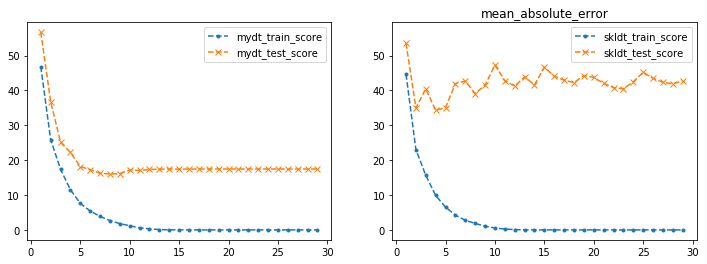

In [16]:
plt.figure(figsize=(12, 4))

mydt  = plot(DecisionTree,
             X_train, y_train, X_test, y_test,
             mean_squared_error,
             'max_depth', range(1, 30),
             [121]
            )
mydt.legend(['mydt_train_score', 'mydt_test_score'])

skldt = plot(tree.DecisionTreeRegressor,
             X_train, y_train, X_test, y_test,
             mean_squared_error,
             'max_depth', range(1, 30),
             [122],
             subplot_kwargs={'sharex':mydt, 'sharey':mydt}
            )
skldt.legend(['skldt_train_score', 'skldt_test_score'])

plt.title('mean_absolute_error')

plt.show()

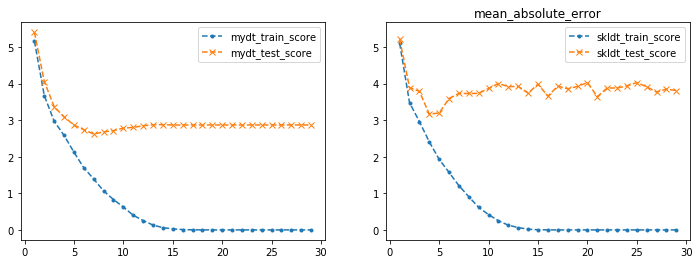

In [17]:
plt.figure(figsize=(12, 4))

mydt  = plot(DecisionTree,
             X_train, y_train, X_test, y_test,
             mean_absolute_error,
             'max_depth', range(1, 30),
             [121]
            )
mydt.legend(['mydt_train_score', 'mydt_test_score'])

skldt = plot(tree.DecisionTreeRegressor,
             X_train, y_train, X_test, y_test,
             mean_absolute_error,
             'max_depth', range(1, 30),
             [122],
             subplot_kwargs={'sharex':mydt, 'sharey':mydt}
            )
skldt.legend(['skldt_train_score', 'skldt_test_score'])

plt.title('mean_absolute_error')

plt.show()